# Trying to Figure out Mixup + TTA bug that messes up eval

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from plant_pathology.all import *
from fastai.vision.all import *

## Build Learner

In [ ]:
dls = get_dls_all_in_1(presize=64, resize=64)

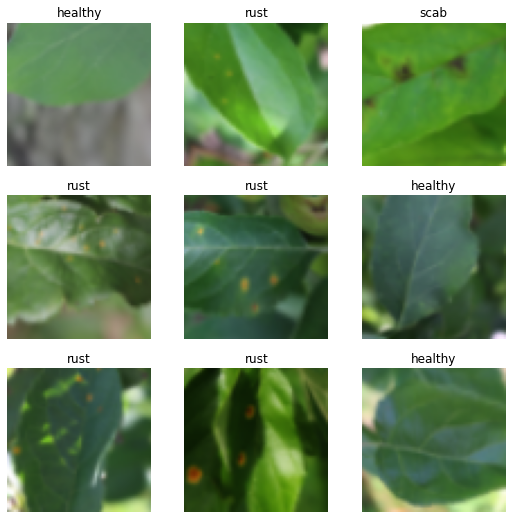

In [ ]:
dls.show_batch()

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=accuracy, cbs=[MixUp()])

In [ ]:
learn.fine_tune(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.156030,2.219089,0.431319,00:27


epoch,train_loss,valid_loss,accuracy,time
0,1.865805,2.036704,0.491758,00:27


In [ ]:
learn.loss_func.activation(tensor([-1.2, 3.7]))

tensor([0.0074, 0.9926])

In [ ]:
path_test = Path("~/kaggle/plant-pathology/data/plant-pathology-2020/test.csv")
df_test = pd.read_csv(path_test)

In [ ]:
test_dl = dls.test_dl(df_test)

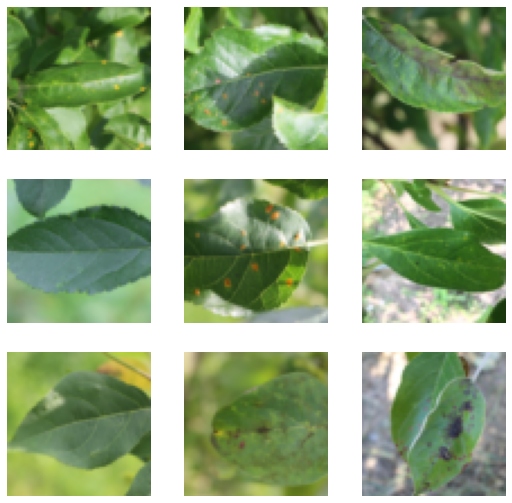

In [ ]:
test_dl.show_batch()

Problem seems to be that .tta is returning raw logits instead of probabilities. But only seems to occur when it's a learner with mixup.

In [ ]:
preds, _ = learn.tta(dl=test_dl)

In [ ]:
preds

tensor([[-0.3743, -0.7677,  3.3352,  0.5156],
        [ 2.5703, -0.5123,  4.4502, -1.7148],
        [-4.4069,  1.4381,  1.8081,  2.1180],
        ...,
        [-1.4539,  1.5102,  3.7277, -0.7546],
        [ 2.5885,  0.8866,  1.7710, -2.0136],
        [ 1.2794, -1.2341,  0.6558, -1.2640]])

In [ ]:
preds2, _ = learn.get_preds(dl=test_dl); preds2

tensor([[-0.0179, -0.6638,  0.9986,  1.1464],
        [ 1.0955, -0.7304,  2.6056, -2.2727],
        [-4.5608,  1.1324,  3.6317, -0.6431],
        ...,
        [-1.1765,  1.4342,  3.8747, -1.3010],
        [ 0.2164,  1.9812,  4.6064, -2.0254],
        [ 2.4857, -1.2260,  1.5768, -1.8193]])

In [ ]:
learn.validate(dl=test_dl)

(#2) [None,None]

Let's remove MixUp and see if that fixes things.

In [ ]:
learn.cbs

(#4) [TrainEvalCallback,Recorder,ProgressCallback,MixUp]

In [ ]:
hasattr(learn, "mix_up")

True

In [ ]:
learn.remove_cb(MixUp)

In [ ]:
learn.cbs

(#3) [TrainEvalCallback,Recorder,ProgressCallback]

In [ ]:
hasattr(learn, "mix_up")

False

In [ ]:
preds, _ = learn.tta(dl=test_dl); preds

tensor([[0.5976, 0.0685, 0.3283, 0.0055],
        [0.7251, 0.0036, 0.2652, 0.0061],
        [0.0149, 0.0227, 0.5923, 0.3702],
        ...,
        [0.2915, 0.0255, 0.6534, 0.0297],
        [0.2077, 0.0186, 0.7391, 0.0346],
        [0.8032, 0.0562, 0.1346, 0.0060]])

In [ ]:
preds2, _ = learn.get_preds(dl=test_dl); preds2

tensor([[9.8794e-01, 3.8446e-04, 1.1460e-02, 2.1309e-04],
        [8.8473e-01, 2.3751e-03, 1.1287e-01, 2.5678e-05],
        [2.6416e-06, 2.5303e-03, 9.2469e-01, 7.2772e-02],
        ...,
        [6.7286e-01, 7.7482e-02, 1.9823e-01, 5.1429e-02],
        [2.5229e-02, 1.3618e-02, 9.6070e-01, 4.5293e-04],
        [9.9816e-01, 1.0269e-04, 1.7367e-03, 6.3842e-07]])

Fantastic, so it seems that MixUp is the problem!

It looks like we might also be able to fix the problem by explicitly passing the activation function we want to get_preds().

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=accuracy, cbs=[MixUp()])

In [ ]:
learn.fine_tune(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.197057,2.709183,0.403846,00:25


epoch,train_loss,valid_loss,accuracy,time
0,1.956090,2.442610,0.409341,00:25


In [ ]:
F.softmax(tensor([[-1., 1.],
                  [-1., 1.]]), dim=1)

tensor([[0.1192, 0.8808],
        [0.1192, 0.8808]])

In [ ]:
preds, _ = learn.get_preds(dl=test_dl); preds

tensor([[ 1.0761,  1.0020,  2.6473, -3.3322],
        [-1.1660, -1.4369,  0.3280, -1.4471],
        [-1.7466,  3.7892,  0.8375, -1.0438],
        ...,
        [-1.5131, -2.7476,  3.7871,  3.1214],
        [-0.7970, -2.0893,  3.1618, -1.0445],
        [ 5.4252, -0.9768,  1.7883, -4.3916]])

In [ ]:
preds2, _ = learn.get_preds(dl=test_dl, act=partial(F.softmax, dim=1)); preds

tensor([[ 1.0761,  1.0020,  2.6473, -3.3322],
        [-1.1660, -1.4369,  0.3280, -1.4471],
        [-1.7466,  3.7892,  0.8375, -1.0438],
        ...,
        [-1.5131, -2.7476,  3.7871,  3.1214],
        [-0.7970, -2.0893,  3.1618, -1.0445],
        [ 5.4252, -0.9768,  1.7883, -4.3916]])

In [ ]:
preds2.sum(dim=1)

tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000])

Alrighty, it looks like that works too! I think I'll do that. **I should create a minimal example and file this as an issue for fastai too.**